## Importing libraries

In [ ]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if tf.config.list_physical_devices('GPU'):
    print('GPU is available. Using GPU for training.')
else:
    print('GPU is not available. Using CPU for training.')

GPU is available. Using GPU for training.


In [ ]:
data_directory = os.path.join(os.getcwd(), 'drive/MyDrive/Covid19-dataset')

## Utility functions

In [ ]:
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()

In [ ]:
height, width = 224, 224
batch_size = 64

TRAINING_DIR = data_directory+'/train'
TESTING_DIR = data_directory+'/test'

In [ ]:
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='sparse',
        target_size=(height, width),
        classes=['Normal', 'Viral Pneumonia', 'Covid']
    )
    return generator

In [ ]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_directory+'/train',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    data_directory+'/test',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Fully Connected Neural Network

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(height, width, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=60,
    verbose=1
)

Epoch 1/60
3/3 [==============================] - 75s 26s/step - loss: 5.6468 - accuracy: 0.3369 - val_loss: 1.5139 - val_accuracy: 0.4219
Epoch 2/60
3/3 [==============================] - 9s 3s/step - loss: 8.0448 - accuracy: 0.3369 - val_loss: 1.5723 - val_accuracy: 0.4062
Epoch 3/60
3/3 [==============================] - 9s 3s/step - loss: 6.9388 - accuracy: 0.4332 - val_loss: 2.2897 - val_accuracy: 0.4062
Epoch 4/60
3/3 [==============================] - 9s 3s/step - loss: 6.6081 - accuracy: 0.3906 - val_loss: 1.2673 - val_accuracy: 0.4219
Epoch 5/60
3/3 [==============================] - 10s 4s/step - loss: 6.7415 - accuracy: 0.3316 - val_loss: 1.5202 - val_accuracy: 0.3906
Epoch 6/60
3/3 [==============================] - 9s 3s/step - loss: 6.4232 - accuracy: 0.3438 - val_loss: 1.3550 - val_accuracy: 0.4062
Epoch 7/60
3/3 [==============================] - 8s 3s/step - loss: 3.8726 - accuracy: 0.3850 - val_loss: 1.2980 - val_accuracy: 0.5000
Epoch 8/60
3/3 [======================

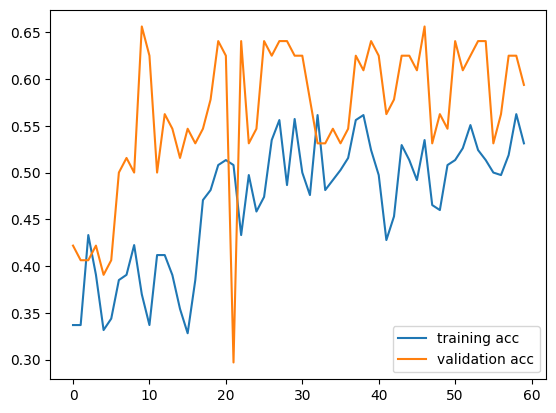

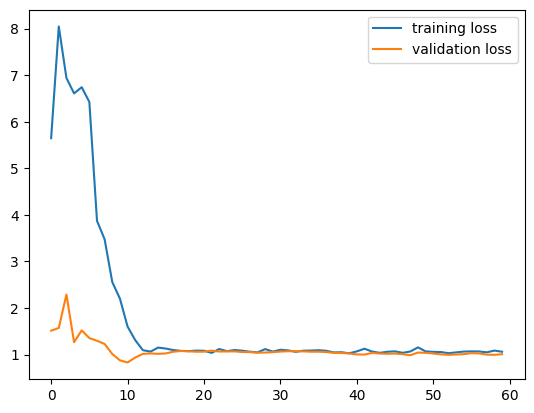

In [ ]:
plot_learning_curve(history)

In [ ]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

eval = pd.DataFrame({
    'Train Acc': [train_result[1]],
    'Val Acc': [test_result[1]]
})
print(eval)

2/2 [==============================] - 1s 43ms/step - loss: 1.0106 - accuracy: 0.5909
   Train Acc   Val Acc
0    0.61753  0.590909


In [ ]:
ytest = test_generator.classes

ypred_prob = model.predict(test_generator)
ypred = np.argmax(ypred_prob, axis=1)

2/2 [==============================] - 1s 43ms/step


[Text(45.72222222222221, 0.5, 'True labels')]

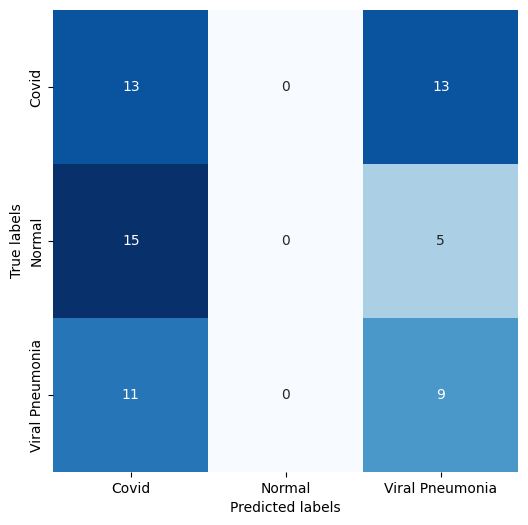

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
hm.set(xlabel='Predicted labels')
hm.set(ylabel='True labels')

In [ ]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40        26
           1       0.00      0.00      0.00        20
           2       0.33      0.45      0.38        20

    accuracy                           0.33        66
   macro avg       0.22      0.32      0.26        66
weighted avg       0.23      0.33      0.27        66



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Test Accuracy:", test_result[1])

Test Accuracy: 0.5909090638160706


### CNN

In [ ]:
model_cnn = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


In [ ]:
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=200,
    verbose=1
)

Epoch 1/200
3/3 [==============================] - 12s 4s/step - loss: 1.0875 - accuracy: 0.4225 - val_loss: 1.1007 - val_accuracy: 0.3906
Epoch 2/200
3/3 [==============================] - 8s 3s/step - loss: 1.0464 - accuracy: 0.4706 - val_loss: 1.0665 - val_accuracy: 0.3906
Epoch 3/200
3/3 [==============================] - 8s 3s/step - loss: 1.0881 - accuracy: 0.3646 - val_loss: 1.0210 - val_accuracy: 0.6406
Epoch 4/200
3/3 [==============================] - 8s 3s/step - loss: 1.0282 - accuracy: 0.5508 - val_loss: 0.9715 - val_accuracy: 0.5469
Epoch 5/200
3/3 [==============================] - 8s 3s/step - loss: 0.9767 - accuracy: 0.5625 - val_loss: 0.9975 - val_accuracy: 0.4062
Epoch 6/200
3/3 [==============================] - 9s 3s/step - loss: 1.0279 - accuracy: 0.4652 - val_loss: 0.9092 - val_accuracy: 0.5000
Epoch 7/200
3/3 [==============================] - 10s 3s/step - loss: 0.9573 - accuracy: 0.5508 - val_loss: 0.8682 - val_accuracy: 0.5312
Epoch 8/200
3/3 [===============

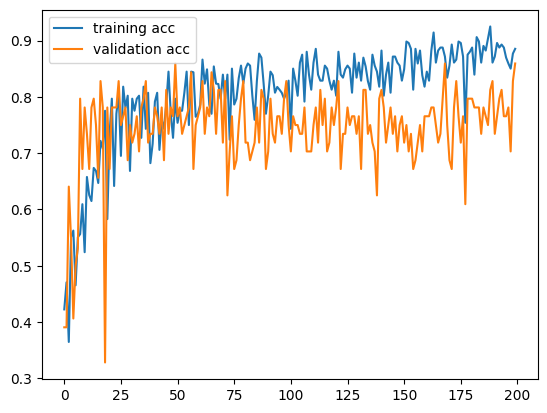

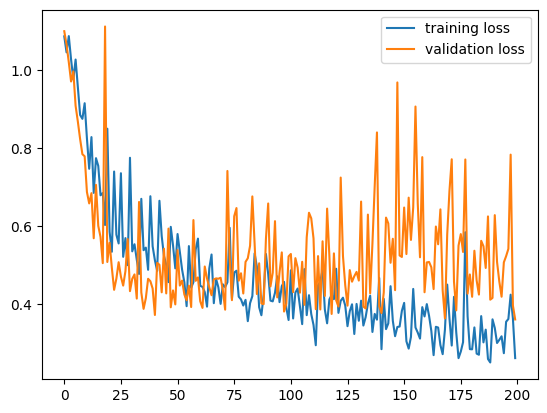

In [ ]:
plot_learning_curve(history_cnn)

In [ ]:
train_result_cnn = model_cnn.evaluate(train_generator)
test_result_cnn = model_cnn.evaluate(test_generator)

eval_cnn = pd.DataFrame({
    'Train Acc': [train_result_cnn[1]],
    'Val Acc': [test_result_cnn[1]]
})
print(eval_cnn)

2/2 [==============================] - 1s 20ms/step - loss: 0.3929 - accuracy: 0.8485
   Train Acc   Val Acc
0   0.888446  0.848485


In [ ]:
# Get true labels of the test data
ytest = test_generator.classes

# Get predicted labels for the test data
ypred_prob = model_cnn.predict(test_generator)
ypred = np.argmax(ypred_prob, axis=1)

2/2 [==============================] - 1s 30ms/step


[Text(45.72222222222221, 0.5, 'True labels')]

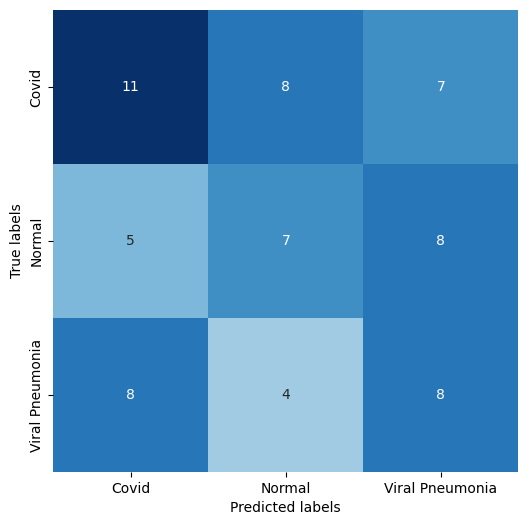

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
hm.set(xlabel='Predicted labels')
hm.set(ylabel='True labels')


In [ ]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.46      0.42      0.44        26
           1       0.37      0.35      0.36        20
           2       0.35      0.40      0.37        20

    accuracy                           0.39        66
   macro avg       0.39      0.39      0.39        66
weighted avg       0.40      0.39      0.39        66



In [ ]:
print("Test Accuracy:", test_result_cnn[1])

Test Accuracy: 0.8484848737716675


### VGG-16

In [ ]:
train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels, test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


In [ ]:
tf.keras.backend.clear_session()

input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=10)

callbacks_list = [checkpoint, early]

history_vgg16 = model_vgg16.fit(
        train_generator,
        validation_data=test_generator,
        epochs=60,
        shuffle=False,
        verbose=True,
        callbacks=callbacks_list
)

Epoch 1/60
4/4 [==============================] - ETA: 0s - loss: 1.1939 - acc: 0.3546 
Epoch 1: acc improved from -inf to 0.35458, saving model to model/vgg16_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 174s 52s/step - loss: 1.1939 - acc: 0.3546 - val_loss: 1.1212 - val_acc: 0.3939
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 1.1377 - acc: 0.4502
Epoch 2: acc improved from 0.35458 to 0.45020, saving model to model/vgg16_best.h5
4/4 [==============================] - 9s 2s/step - loss: 1.1377 - acc: 0.4502 - val_loss: 1.0174 - val_acc: 0.3939
Epoch 3/60
4/4 [==============================] - ETA: 0s - loss: 1.0216 - acc: 0.4502
Epoch 3: acc did not improve from 0.45020
4/4 [==============================] - 8s 2s/step - loss: 1.0216 - acc: 0.4502 - val_loss: 0.9546 - val_acc: 0.6818
Epoch 4/60
4/4 [==============================] - ETA: 0s - loss: 0.9804 - acc: 0.5179
Epoch 4: acc improved from 0.45020 to 0.51793, saving model to model/vgg16_best.h5
4/4 [==============================] - 8s 2s/step - loss: 0.9804 - acc: 0.5179 - val_loss: 0.9031 - val_acc: 0.6818
Epoch 5/60
4/4 [==============================] - ETA: 0s - loss

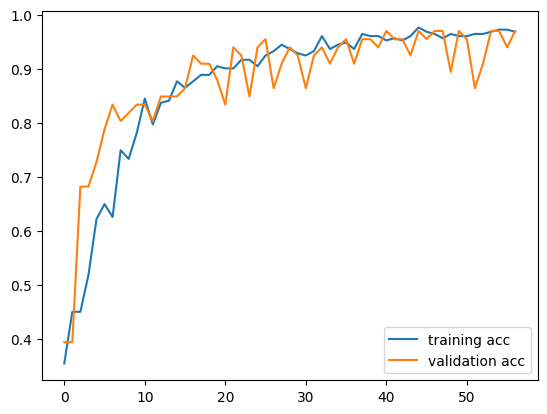

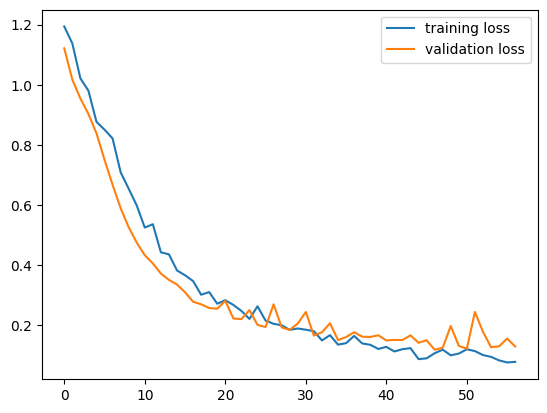

In [ ]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()

plot_learning_curve(history_vgg16)

In [ ]:
train_result_vgg16 = model_vgg16.evaluate(train_generator)
test_result_vgg16 = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result_vgg16, test_result_vgg16), columns=['Train', 'Val'], index=['Loss', 'Acc'])
no_augmented_df

2/2 [==============================] - 1s 27ms/step - loss: 0.1196 - acc: 0.9697


,Train,Val
Loss,0.063507,0.119600
Acc,0.976096,0.969697


In [ ]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0])
    ytest = np.concatenate((ytest, test_generator[i][-1]))

xtest = np.concatenate((xtest), axis=0)

ypred_prob = model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob, axis=1)


3/3 [==============================] - 8s 76ms/step


              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        20
         1.0       0.91      1.00      0.95        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



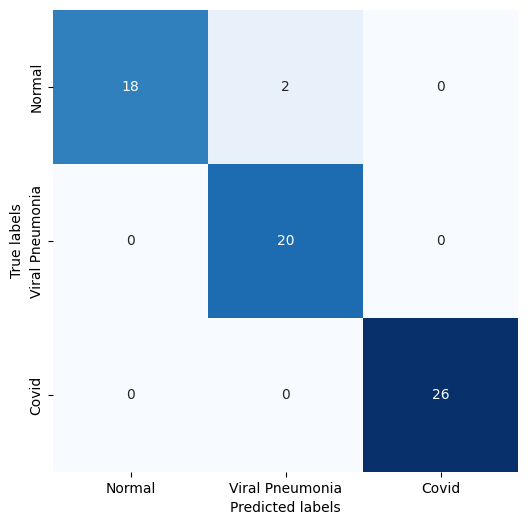

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest, ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Viral Pneumonia', 'Covid'], yticklabels=['Normal', 'Viral Pneumonia', 'Covid'])
hm.set(xlabel='Predicted labels')
hm.set(ylabel='True labels')

print(classification_report(ytest, ypred))

In [ ]:
no_augmented_df = pd.DataFrame({
    'Train Acc': [train_result_vgg16[1]],
    'Val Acc': [test_result_vgg16[1]]
})
no_augmented_df

,Train Acc,Val Acc
0,0.976096,0.969697


In [ ]:
print("Test Accuracy:", test_result_vgg16[1])

Test Accuracy: 0.9696969985961914
